<a href="https://colab.research.google.com/github/aratinj/ovi_kaggle/blob/main/cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load data

In [ ]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification

Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification
License(s): CC0-1.0
 99% 538M/545M [00:04<00:00, 129MB/s]
100% 545M/545M [00:04<00:00, 131MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cat-dog-images-for-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Import library

In [ ]:
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling1D

In [ ]:
dir = '/content/cat_dog'

cat_dir = os.path.join(dir, 'cat')
dog_dir = os.path.join(dir, 'dog')

os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

cat_count = 0
dog_count = 0
for file in os.listdir(dir):
  if file.startswith('cat') or file.startswith('dog'):
    if 'cat' in file:
      cat_count += 1
    elif 'dog' in file:
      dog_count += 1

# #or
# dir = '/content/cat_dog'

# cat_dir = os.path.join(dir, 'cat')
# dog_dir = os.path.join(dir, 'dog')

# os.makedirs(cat_dir, exist_ok=True)
# os.makedirs(dog_dir, exist_ok=True)

# for file in os.listdir(dir):
#   if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.bmp') or file.endswith('.jpeg') or file.endswith('.gif'):
#    if 'cat' in file:
#      shutil.move(os.path.join(dir, file), cat_dir)
#    elif 'dog' in file:
#      shutil.move(os.path.join(dir, file), dog_dir)

In [ ]:
train = keras.utils.image_dataset_from_directory(directory = '/content/cat_dog',
                                        labels = 'inferred',
                                        label_mode = 'int',
                                        batch_size = 32,
                                        image_size = (256, 256),
                                        validation_split = 0.2,
                                        subset = 'training',
                                        seed=42
                                                )
val = keras.utils.image_dataset_from_directory(directory = '/content/cat_dog',
                                        labels = 'inferred',
                                        label_mode = 'int',
                                        batch_size = 32,
                                        image_size = (256, 256),
                                        validation_split = 0.2,
                                        subset = 'validation',
                                        seed=42
                                              )

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
def process(image, label):
   image = tf.cast(image / 255., tf.float32)
   return image, label

train = train.map(process)
val = val.map(process)

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3,3), padding = 'valid',activation = 'relu', input_shape = (256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'valid', strides = 2))


model.add(Conv2D(64, kernel_size = (3,3), padding = 'valid',activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'valid', strides = 2))


model.add(Conv2D(128, kernel_size = (3,3), padding = 'valid',activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'valid', strides = 2))

model.add(Flatten())

model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model_history = model.fit(train, epochs = 10, validation_data = val)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 92ms/step - accuracy: 0.5475 - loss: 2.9947 - val_accuracy: 0.6204 - val_loss: 0.6750
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - accuracy: 0.6381 - loss: 0.6555 - val_accuracy: 0.6780 - val_loss: 0.5982
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.7062 - loss: 0.5606 - val_accuracy: 0.7386 - val_loss: 0.5185
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.7659 - loss: 0.4752 - val_accuracy: 0.7690 - val_loss: 0.4939
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.8063 - loss: 0.4138 - val_accuracy: 0.7622 - val_loss: 0.5054
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 82ms/step - accuracy: 0.8318 - loss: 0.3691 - val_accuracy: 0.7352 - val_loss: 0.5733
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.8491 - loss: 0.3322 - val_accuracy: 0.7904 - val_loss: 0.4393
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 81ms/step - accuracy: 0.8846 - loss: 0.2690 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(val, verbose=0) # Remove 'train' as an argument
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 81.28%


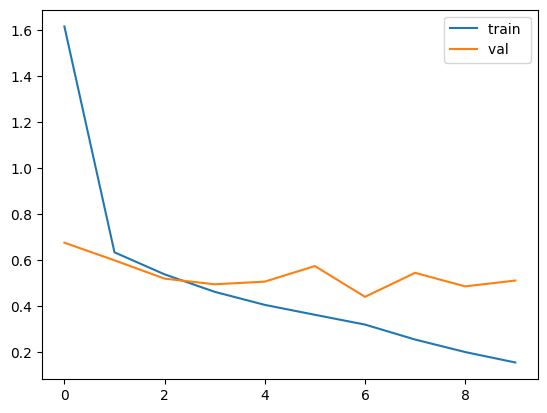

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_history.history['loss'], label ='train ')
plt.plot(model_history.history['val_loss'], label ='val ')
plt.legend()

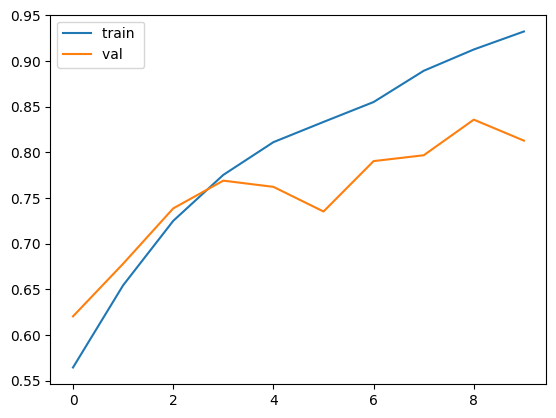

In [ ]:
plt.plot(model_history.history['accuracy'], label ='train ')
plt.plot(model_history.history['val_accuracy'], label ='val ')
plt.legend()

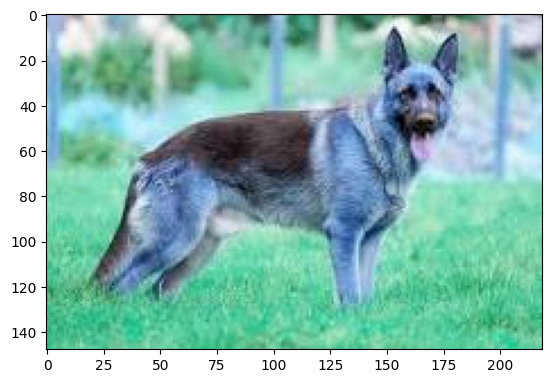

In [ ]:
import cv2
test_image = cv2.imread('/content/dog.jpg')
plt.imshow(test_image)

In [ ]:
test_image.shape

(148, 219, 3)

In [ ]:
test_image = cv2.resize(test_image, (256, 256))

In [ ]:
test_input = test_image.reshape((1,256,256,3))

In [ ]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step


array([[1.]], dtype=float32)

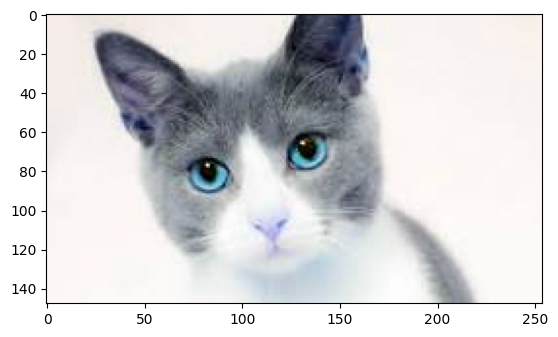

In [ ]:
import cv2
cat_image = cv2.imread('/content/cat.jpg')
plt.imshow(cat_image)

In [ ]:
cat_image.shape

(148, 254, 3)

In [ ]:
cat_image = cv2.resize(cat_image, (256, 256))

In [ ]:
cat_input = cat_image.reshape((1,256,256,3))

In [ ]:
model.predict(cat_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[0.41820097]], dtype=float32)

In [ ]:
dir = '/content/cat_dog'
cat_dir = os.path.join(dir, 'cat')
dog_dir = os.path.join(dir, 'dog')

os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

cat_count = 0
dog_count = 0
for file in os.listdir(dir):
    if file.startswith('cat'):
        if 'cat' in file:
            cat_count += 1
            print(f'{file} is cat')

    elif file.startswith('dog'):
        if 'dog' in file:
            dog_count += 1
            print(f'{file} is dog')

print(f'Total cats: {cat_count}')
print(f'Total dogs: {dog_count}')

Streaming output truncated to the last 5000 lines.
cat.3853.jpg is cat
cat.3203.jpg is cat
cat.2421.jpg is cat
dog.6921.jpg is dog
dog.10398.jpg is dog
dog.8277.jpg is dog
dog.5310.jpg is dog
cat.11199.jpg is cat
cat.10538.jpg is cat
cat.4230.jpg is cat
dog.4936.jpg is dog
cat.9756.jpg is cat
dog.4998.jpg is dog
dog.7985.jpg is dog
cat.3673.jpg is cat
dog.1391.jpg is dog
dog.3842.jpg is dog
dog.4641.jpg is dog
cat.5245.jpg is cat
cat.1498.jpg is cat
dog.5318.jpg is dog
cat.4154.jpg is cat
cat.177.jpg is cat
cat.11950.jpg is cat
dog.3962.jpg is dog
dog.11202.jpg is dog
dog.11365.jpg is dog
dog.7575.jpg is dog
dog.9820.jpg is dog
cat.9375.jpg is cat
cat.289.jpg is cat
cat.7696.jpg is cat
cat.8025.jpg is cat
cat.11219.jpg is cat
dog.622.jpg is dog
dog.2954.jpg is dog
cat.9193.jpg is cat
cat.12230.jpg is cat
cat.11439.jpg is cat
dog.9701.jpg is dog
dog.3926.jpg is dog
dog.2517.jpg is dog
dog.10708.jpg is dog
cat.957.jpg is cat
dog.1217.jpg is dog
cat.2394.jpg is cat
dog.12215.jpg is dog
ca

In [ ]:
train = keras.preprocessing.image_dataset_from_directory(
    directory = '/content/cat_dog',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256, 256),
    seed = 20,
    validation_split = 0.3,
    subset = 'training'
)
val = keras.preprocessing.image_dataset_from_directory(
    directory = '/content/cat_dog',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256, 256),
    seed = 20,
    validation_split = 0.3,
    subset = 'validation'
)

Found 25000 files belonging to 2 classes.
Using 17500 files for training.
Found 25000 files belonging to 2 classes.
Using 7500 files for validation.


In [ ]:
def process(image, label):
   image = tf.cast(image / 255., tf.float32)
   return image, label

train = train.map(process)
val = val.map(process)

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3,3),padding = 'valid', activation = 'relu', input_shape =(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'valid', strides = 2))

model.add(Conv2D(64, kernel_size = (3,3),padding = 'valid', activation = 'relu', input_shape =(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'valid', strides = 2))

model.add(Conv2D(128, kernel_size = (3,3),padding = 'valid', activation = 'relu', input_shape =(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'valid', strides = 2))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(1, activation = 'sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
earlystopping = EarlyStopping(monitor = 'val_loss', patience =3, restore_best_weights = True)
lr_ra = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2)

In [ ]:
model_history = model.fit(train, epochs = 10, validation_data = val, callbacks = [earlystopping, lr_ra])

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 72s 105ms/step - accuracy: 0.5692 - loss: 2.5174 - val_accuracy: 0.6243 - val_loss: 0.6354 - learning_rate: 0.0010
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 63s 93ms/step - accuracy: 0.6997 - loss: 0.5806 - val_accuracy: 0.6863 - val_loss: 0.6136 - learning_rate: 0.0010
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 91s 111ms/step - accuracy: 0.7454 - loss: 0.5118 - val_accuracy: 0.6813 - val_loss: 0.5873 - learning_rate: 0.0010
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 78s 103ms/step - accuracy: 0.7923 - loss: 0.4466 - val_accuracy: 0.7755 - val_loss: 0.4921 - learning_rate: 0.0010
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - accuracy: 0.8246 - loss: 0.3970 - val_accuracy: 0.7632 - val_loss: 0.4880 - learning_rate: 0.0010
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 77s 94ms/step - accuracy: 0.8568 - loss: 0.3225 - val_accuracy: 0.7817 - val_loss: 0.5034 - learning_rate: 0.0010
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 79s 90ms/step - accuracy: 0.8921

In [ ]:
test_loss, test_accuracy = model.evaluate(val, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 76.32%


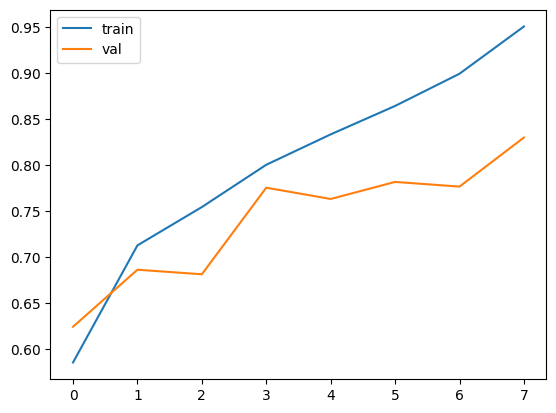

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_history.history['accuracy'], label = 'train')
plt.plot(model_history.history['val_accuracy'], label = 'val')
plt.legend()

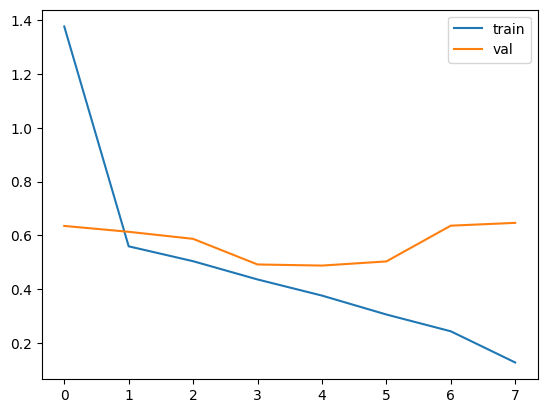

In [ ]:
plt.plot(model_history.history['loss'], label = 'train')
plt.plot(model_history.history['val_loss'], label = 'val')
plt.legend()

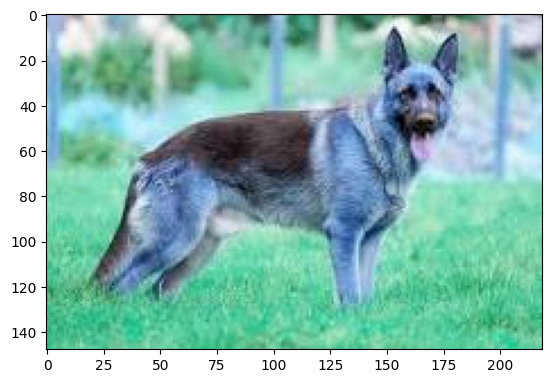

In [ ]:
import cv2
dog_image = cv2.imread('/content/dog.jpg')
plt.imshow(dog_image)

In [ ]:
dog_image.shape

(148, 219, 3)

In [ ]:
dog_image = cv2.resize(dog_image, (256, 256))

In [ ]:
dog_image.shape

(256, 256, 3)